# NLP PROJECT ON HEALTHCARE DATA

In [ ]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# NLP & ML
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)


# Data sourcing

In [13]:
#    - Load healthcare dataset
#    - Construct text field that mimics a clinical/social post
#    - Construct a keywords/metadata column linked to the text


# Load dataset
df = pd.read_csv("healthcare_dataset.csv")

print("Shape of dataset:", df.shape)
print(df.head())

# Create a "text" column that combines several fields into a narrative-style string.
# This will act as our "post" or "text data" for NLP.
df["text"] = (
    "Patient " + df["Name"].astype(str)
    + " (" + df["Gender"].astype(str) + ", " + df["Age"].astype(str) + " years) "
    + "was admitted on " + df["Date of Admission"].astype(str)
    + " with " + df["Medical Condition"].astype(str) + ". "
    + "Admission type: " + df["Admission Type"].astype(str) + ". "
    + "Medication: " + df["Medication"].astype(str) + ". "
    + "Test result: " + df["Test Results"].astype(str) + "."
)

# Create a simple "keywords" column with domain-specific keywords
df["keywords"] = (
    df["Medical Condition"].astype(str).str.lower()
    + ", " + df["Admission Type"].astype(str).str.lower()
    + ", " + df["Medication"].astype(str).str.lower()
)

# Show a few examples of our constructed text + keywords
df[["text", "keywords"]].head(5)


Shape of dataset: (55500, 15)
            Name  Age  Gender Blood Type Medical Condition Date of Admission  \
0  Bobby JacksOn   30    Male         B-            Cancer        2024-01-31   
1   LesLie TErRy   62    Male         A+           Obesity        2019-08-20   
2    DaNnY sMitH   76  Female         A-           Obesity        2022-09-22   
3   andrEw waTtS   28  Female         O+          Diabetes        2020-11-18   
4  adrIENNE bEll   43  Female        AB+            Cancer        2022-09-19   

             Doctor                    Hospital Insurance Provider  \
0     Matthew Smith             Sons and Miller         Blue Cross   
1   Samantha Davies                     Kim Inc           Medicare   
2  Tiffany Mitchell                    Cook PLC              Aetna   
3       Kevin Wells  Hernandez Rogers and Vang,           Medicare   
4    Kathleen Hanna                 White-White              Aetna   

   Billing Amount  Room Number Admission Type Discharge Date   Medic

,text,keywords
0,"Patient Bobby JacksOn (Male, 30 years) was adm...","cancer, urgent, paracetamol"
1,"Patient LesLie TErRy (Male, 62 years) was admi...","obesity, emergency, ibuprofen"
2,"Patient DaNnY sMitH (Female, 76 years) was adm...","obesity, emergency, aspirin"
3,"Patient andrEw waTtS (Female, 28 years) was ad...","diabetes, elective, ibuprofen"
4,"Patient adrIENNE bEll (Female, 43 years) was a...","cancer, urgent, penicillin"


# Research questions / objectives

**RQ1:** What is the overall distribution of "health sentiment" in the hospital
     (positive vs negative) based on patient test results?

**RQ2:** Can we predict a patient's sentiment label (positive/negative health status)
     from our text descriptions (constructed from medical condition, admission
     type, medication, and test results)?

**RQ3:** Which terms/phrases in patient descriptions are most useful for
     distinguishing between positive and negative sentiment?

# Data preprocessing + EDA

Sentiment value counts:
sentiment
negative    0.66636
positive    0.33364
Name: proportion, dtype: float64

Missing values per column:
Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
text                  0
keywords              0
sentiment             0
dtype: int64

Summary statistics for text length:
count    55500.000000
mean       153.388414
std          4.575471
min        139.000000
25%        150.000000
50%        153.000000
75%        156.000000
max        173.000000
Name: text_len, dtype: float64


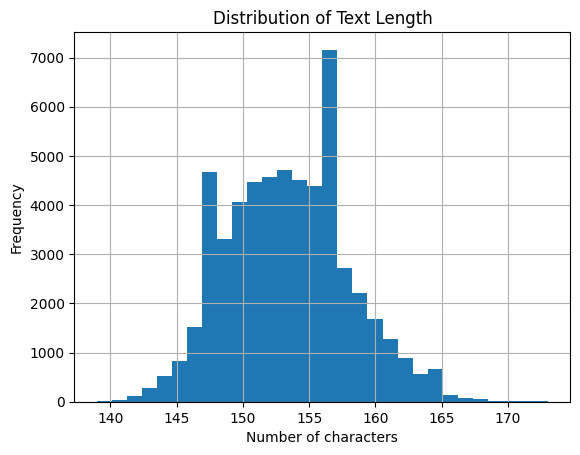

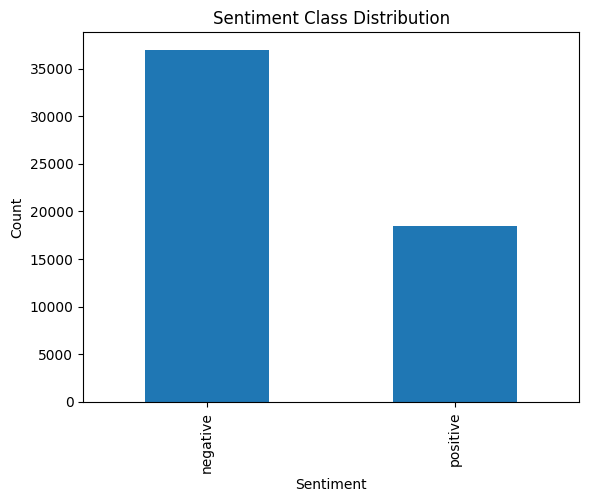

In [14]:
# 3.1 Create a sentiment label from 'Test Results'

# Assumption:
#   - "Normal"  -> positive sentiment
#   - "Abnormal" or "Inconclusive" -> negative sentiment

df["sentiment"] = np.where(df["Test Results"] == "Normal", "positive", "negative")

# Check class distribution (this answers RQ1)
print("Sentiment value counts:")
print(df["sentiment"].value_counts(normalize=True))


# 3.2 Basic EDA

print("\nMissing values per column:")
print(df.isna().sum())

# Length of text (number of characters) for simple EDA
df["text_len"] = df["text"].str.len()

print("\nSummary statistics for text length:")
print(df["text_len"].describe())

# Plot distribution of text length
plt.figure()
df["text_len"].hist(bins=30)
plt.title("Distribution of Text Length")
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.show()

# Plot sentiment counts
plt.figure()
df["sentiment"].value_counts().plot(kind="bar")
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Preprocessing of text for NLP

In [15]:
# 3.3 Text cleaning function

def clean_text(text):
    """
    Basic text cleaning:
    - Lowercase
    - Remove non-alphabetic characters
    - Remove stopwords
    """
    # Lowercase
    text = text.lower()
    # Keep only letters and spaces
    text = re.sub(r"[^a-z\s]", " ", text)
    # Tokenize by whitespace
    tokens = text.split()
    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    # Rejoin
    return " ".join(tokens)

# Apply cleaning to create a new column
df["clean_text"] = df["text"].apply(clean_text)

# Compare original vs cleaned text examples
df[["text", "clean_text"]].head(5)


,text,clean_text
0,"Patient Bobby JacksOn (Male, 30 years) was adm...",patient bobby jackson male years admitted canc...
1,"Patient LesLie TErRy (Male, 62 years) was admi...",patient leslie terry male years admitted obesi...
2,"Patient DaNnY sMitH (Female, 76 years) was adm...",patient danny smith female years admitted obes...
3,"Patient andrEw waTtS (Female, 28 years) was ad...",patient andrew watts female years admitted dia...
4,"Patient adrIENNE bEll (Female, 43 years) was a...",patient adrienne bell female years admitted ca...


# Sentiment classification model

In [16]:
# 4.1 Train-test split

X = df["clean_text"]
y = df["sentiment"]  # 'positive' or 'negative'

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 80% train, 20% test
    random_state=42,
    stratify=y        
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


# 4.2 TF-IDF Vectorization

tfidf = TfidfVectorizer(
    max_features=5000,   # limit vocabulary size
    ngram_range=(1, 2)   # unigrams + bigrams to capture phrases
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF matrix shape (train):", X_train_tfidf.shape)


# 4.3 Train a classification model (Logistic Regression)

clf = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

clf.fit(X_train_tfidf, y_train)

print("Model trained successfully.")


Train size: 44400
Test size: 11100
TF-IDF matrix shape (train): (44400, 5000)
Model trained successfully.


# Model evaluation (accuracy + detailed metrics)

Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      7397
    positive       1.00      1.00      1.00      3703

    accuracy                           1.00     11100
   macro avg       1.00      1.00      1.00     11100
weighted avg       1.00      1.00      1.00     11100

Confusion Matrix (rows=true, cols=pred):
[[3703    0]
 [   0 7397]]


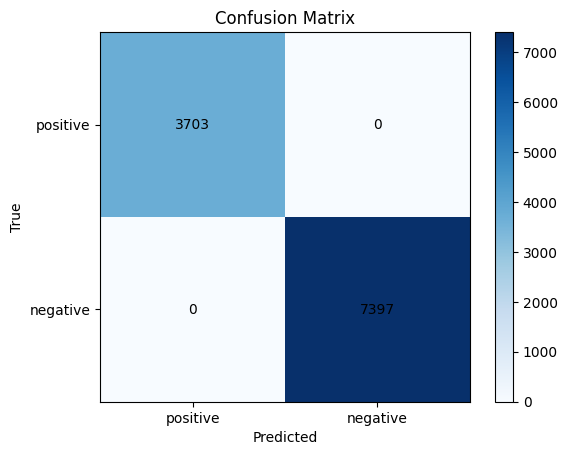

In [17]:
# 5. MODEL EVALUATION


# 5.1 Predictions
y_pred = clf.predict(X_test_tfidf)

# 5.2 Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# 5.3 Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# 5.4 Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["positive", "negative"])
print("Confusion Matrix (rows=true, cols=pred):")
print(cm)

plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0, 1], ["positive", "negative"])
plt.yticks([0, 1], ["positive", "negative"])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.colorbar()
plt.show()


In [18]:
# WHICH TERMS MATTER MOST? (For RQ3)

feature_names = np.array(tfidf.get_feature_names_out())
coeffs = clf.coef_[0]  # For binary classification, shape (n_features,)

# Top features for positive sentiment
top_pos_idx = np.argsort(coeffs)[-20:]
top_pos_words = feature_names[top_pos_idx]
top_pos_weights = coeffs[top_pos_idx]

print("Top positive sentiment indicators:")
for w, c in sorted(zip(top_pos_words, top_pos_weights), key=lambda x: x[1], reverse=True):
    print(f"{w:20s} {c:.4f}")

# Top features for negative sentiment
top_neg_idx = np.argsort(coeffs)[:20]
top_neg_words = feature_names[top_neg_idx]
top_neg_weights = coeffs[top_neg_idx]

print("\nTop negative sentiment indicators:")
for w, c in sorted(zip(top_neg_words, top_neg_weights), key=lambda x: x[1]):
    print(f"{w:20s} {c:.4f}")


Top positive sentiment indicators:
normal               25.3910
result normal        25.3910
patient david        0.1557
david                0.1434
patient thomas       0.1396
howard               0.1379
robinson             0.1364
jeffrey              0.1269
parker               0.1219
jordan               0.1179
william              0.1165
derek                0.1146
jacqueline           0.1078
patient paul         0.1074
patient jeffrey      0.1072
michael              0.1068
james                0.1067
patient michael      0.1065
patient derek        0.1037
arnold               0.1028

Top negative sentiment indicators:
abnormal             -12.8088
result abnormal      -12.8088
inconclusive         -12.6958
result inconclusive  -12.6958
patient jonathan     -0.1260
jonathan             -0.1207
green                -0.1161
baker male           -0.1115
patient aaron        -0.1053
patient courtney     -0.1022
jennifer             -0.1004
brenda               -0.0998
green male     